In [1]:
# Jairo Andres Saavedra Alfonso
# 01 de Febrero de 2019
# Universidad de Los Andes
# Phycis 
######################__________________Report 01__________________######################

(1, 2004)


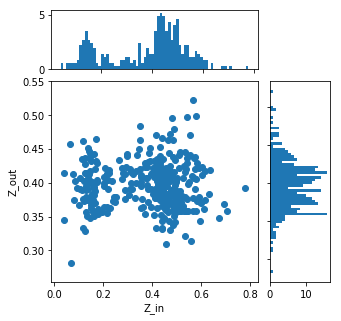

In [18]:
#Packages
from astropy.io import fits
import numpy as np
import matplotlib.pylab as plt
import pandas as pd
import torch 
import torch.nn as nn
from sklearn.model_selection import train_test_split
from torch.autograd import Variable
import torch.utils.data
from matplotlib.gridspec import GridSpec

dta=np.genfromtxt('data.txt')
d=dta.reshape(1,-1)
print(d.shape)

y_pred=d[0,:348]
y_test=d[0,348:696]


# the random data
x = y_test
y = y_pred


fig = plt.figure(figsize=(5,5 ))

gs = GridSpec(4,4)

ax_joint = fig.add_subplot(gs[1:4,0:3])
ax_marg_x = fig.add_subplot(gs[0,0:3])
ax_marg_y = fig.add_subplot(gs[1:4,3])

ax_joint.scatter(x,y)
ax_marg_x.hist(x,70,density=True)
ax_marg_y.hist(y,70,density=True,orientation="horizontal")

# Turn off tick labels on marginals
plt.setp(ax_marg_x.get_xticklabels(), visible=False)
plt.setp(ax_marg_y.get_yticklabels(), visible=False)

# Set labels on joint
ax_joint.set_xlabel('Z_in')
ax_joint.set_ylabel('Z_out')
plt.savefig('z_invsz_out_58k_QQBAL.jpg')
# Set labels on marginals
#ax_marg_y.set_xlabel('')
#ax_marg_x.set_ylabel('Marginal y label')



(174,) (174,)


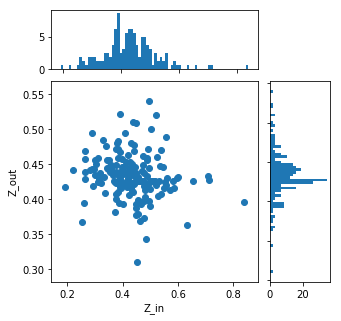

In [12]:


y_pred=d[0,696:870]
y_test=d[0,870:1044]

print(y_pred.shape,y_test.shape)
# the random data
x = y_test
y = y_pred


fig = plt.figure(figsize=(5,5 ))

gs = GridSpec(4,4)

ax_joint = fig.add_subplot(gs[1:4,0:3])
ax_marg_x = fig.add_subplot(gs[0,0:3])
ax_marg_y = fig.add_subplot(gs[1:4,3])

ax_joint.scatter(x,y)
ax_marg_x.hist(x,70,density=True)
ax_marg_y.hist(y,70,density=True,orientation="horizontal")

# Turn off tick labels on marginals
plt.setp(ax_marg_x.get_xticklabels(), visible=False)
plt.setp(ax_marg_y.get_yticklabels(), visible=False)

# Set labels on joint
ax_joint.set_xlabel('Z_in')
ax_joint.set_ylabel('Z_out')
plt.savefig('z_invsz_out_29k_QSOBAL.jpg')
# Set labels on marginals
#ax_marg_y.set_xlabel('')
#ax_marg_x.set_ylabel('Marginal y label')

(160, 6)
(0,) (0,)


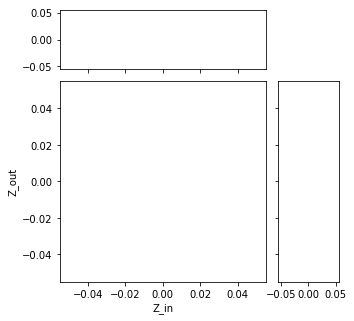

In [22]:
data=np.genfromtxt('d.txt')
d=data.reshape(1,-1)
print(data.shape)


y_pred=d[0,1044:9044]
y_test=d[0,9044:]

print(y_pred.shape,y_test.shape)
# the random data
x = y_test
y = y_pred


fig = plt.figure(figsize=(5,5 ))

gs = GridSpec(4,4)

ax_joint = fig.add_subplot(gs[1:4,0:3])
ax_marg_x = fig.add_subplot(gs[0,0:3])
ax_marg_y = fig.add_subplot(gs[1:4,3])

ax_joint.scatter(x,y)
ax_marg_x.hist(x,70,density=True)
ax_marg_y.hist(y,70,density=True,orientation="horizontal")

# Turn off tick labels on marginals
plt.setp(ax_marg_x.get_xticklabels(), visible=False)
plt.setp(ax_marg_y.get_yticklabels(), visible=False)

# Set labels on joint
ax_joint.set_xlabel('Z_in')
ax_joint.set_ylabel('Z_out')
plt.savefig('z_invsz_out_29k_QSOBAL.jpg')
# Set labels on marginals
#ax_marg_y.set_xlabel('')
#ax_marg_x.set_ylabel('Marginal y label')

In [2]:

def Load_Files(file_1,file_2,N_sample=20000,classification=True):
    hdul = fits.open(file_1) # Open file 1 -- 'truth_DR12Q.fits'
    info=hdul.info() # File info
    columns=hdul[1].columns # File Columns 
    print(info,'/n',columns)
    data=hdul[1].data # Database of spectra with human-expert classifications 

    # Reading data from data_dr12.fits. This file had the spectra from data dr12. 
    hdul_2 = fits.open(file_2) # Open file 2 -- 'data_dr12.fits'
    info=hdul_2.info() # File info 
    columns=hdul_2[1].columns # File Columns
    print(hdul,'/n',columns)
    data2=hdul_2[1].data # Database of spectra
    spectra=hdul_2[0].data # Spectrum of each object 
    
    # Subset of PLATE parameters of both data
    data_PLATE_1=data['PLATE']
    data_PLATE_2=data2['PLATE']

    # Subset of MJD parameters of both data
    data_MJD_1=data['MJD']
    data_MJD_2=data2['MJD']

    # Subset of FIBERID parameters of both data
    data_FIBERID_1=data['FIBERID']
    data_FIBERID_2=data2['FIBERID']
    data_ID_1=data['THING_ID']
    data_ID_2=data2['TARGETID']
    
    # The column 'CLASS_PERSON' have a class identifier for each spectrum: STARS=1, GALAXY=4, QSO=3 and QSO_BAL=30.
    C_P=data['CLASS_PERSON'] #Class Person column 
    STAR=C_P[C_P==1] # objects classified as stars
    GALAXY=C_P[C_P==4] # objects classified as galaxies 
    QSO=C_P[C_P==3] # objects classified as QSO (Quasars)
    QSO_BAL=C_P[C_P==30] # objects classified as QSO BAL (Quasars with Broad Absortions Lines)
    N_C=C_P[C_P!=30]   
    N_C=N_C[N_C!=3]
    N_C=N_C[N_C!=1]
    N_C=N_C[N_C!=4] # objects wrong classified
    print('Star:',STAR.shape)
    print('Galaxy:',GALAXY.shape)
    print('QSO:',QSO.shape)
    print('QSO BAL:',QSO_BAL.shape)
    print('NN:',N_C.shape)
    
    # I create two DataFrame for Superset_DR12Q and data_dr12 with only three parameters
    data1={'PLATE':data_PLATE_1,'MJD':data_MJD_1,'FIBERID':data_FIBERID_1,'ID':data_ID_1}
    data1=pd.DataFrame(data=data1)

    data2={'PLATE':data_PLATE_2,'MJD':data_MJD_2,'FIBERID':data_FIBERID_2,'ID':data_ID_2}
    data2=pd.DataFrame(data=data2)

    # I convert all objects in both set to string chain in orden to combine them as one new ID.
    data1['PLATE']=data1['PLATE'].astype(str)
    data1['MJD']=data1['MJD'].astype(str)
    data1['FIBERID']=data1['FIBERID'].astype(str)
    data1['PM'] = data1['MJD'].str.cat(data1['FIBERID'],sep="-")
    data1['NEWID'] = data1['PLATE'].str.cat(data1['PM'],sep="-")
    data_1=data1.drop(columns=['PLATE','MJD','FIBERID','ID','PM']).values

    data2['PLATE']=data2['PLATE'].astype(str)
    data2['MJD']=data2['MJD'].astype(str)
    data2['FIBERID']=data2['FIBERID'].astype(str)
    data2['PM'] = data2['MJD'].str.cat(data2['FIBERID'],sep="-")
    data2['NEWID'] = data2['PLATE'].str.cat(data2['PM'],sep="-")
    data_2=data2.drop(columns=['PLATE','MJD','FIBERID','ID','PM']).values # New set of database 2 with new ID's
    print(data_2.shape)

    # With the routine of numpy intersect1d, I find the intersections elements in both sets. This elements  
    data_CO=np.array(np.intersect1d(data_1,data_2,return_indices=True))

    data_CO_objects=data_CO[0] # The unique new ID of each element in both sets
    data_CO_ind1=data_CO[1] # Indices of intersected elements from the original data 1 (Superset_DR12Q.fits) 
    data_CO_ind2=data_CO[2] # Indices of intersected elements form the original data 2 (data_dr12.fits)
    print('I find',len(data_CO_objects),'objects with spectra from DR12')
    print(data_CO_ind1,data_CO_ind2)
    indi={'ind1':data_CO_ind1,'ind2':data_CO_ind2}
    ind=pd.DataFrame(data=indi,index=data_CO_ind1)

    cp=np.array(data['CLASS_PERSON'],dtype=float)
    z=np.array(data['Z_VI'],dtype=float)
    zc=np.array(data['Z_CONF_PERSON'],dtype=float)
    bal=np.array(data['BAL_FLAG_VI'],dtype=float)
    bi=np.array(data['BI_CIV'],dtype=float)

    d={'CLASS_PERSON':cp,'Z_VI':z,'Z_CONF_PERSON':zc,'BAL_FLAG_VI':bal,'BI_CIV':bi}
    data_0=pd.DataFrame(data=d)#.values #super database
    obj=data_0.loc[data_CO_ind1]

    print(obj.shape)
    # Sample of objects. I chosen 2500 object per class. 
    stars=obj.loc[obj['CLASS_PERSON']==1]
    galaxies=obj.loc[obj['CLASS_PERSON']==4]
    qsos=obj.loc[obj['CLASS_PERSON']==3]
    qsos_bal=obj.loc[obj['CLASS_PERSON']==30]

    sample_star=stars.sample(n=int(N_sample/4),weights='CLASS_PERSON', random_state=5)
    sample_galaxy=galaxies.sample(n=int(N_sample/4),weights='CLASS_PERSON', random_state=5)
    sample_qso=qsos.sample(n=int(N_sample/4),weights='CLASS_PERSON', random_state=5)
    sample_qso_bal=qsos_bal.sample(n=int(N_sample/4),weights='CLASS_PERSON', random_state=5)

    sample_objects=pd.concat([sample_star,sample_galaxy,sample_qso,sample_qso_bal])

    ind_star=np.array(sample_star.index)
    ind_galaxy=np.array(sample_galaxy.index)
    ind_qso=np.array(sample_qso.index)
    ind_qso_bal=np.array(sample_qso_bal.index)

    indi=np.concatenate((ind_star, ind_galaxy,ind_qso,ind_qso_bal), axis=None)
    indi1=ind.loc[indi].values
    #print(indi)

    spectra_=np.zeros((N_sample,443))
    j=0
    for i in indi:
        k=indi1[j,1]
        spectra_[j,:]=np.log(abs(spectra[k,:443]))
        j=j+1    
    spectra_=pd.DataFrame(spectra_)
    X=spectra_.replace(-np.inf,0)


    X=X.values # Spectra
    
    if(classification!=True):
        y=sample_objects['Z_VI']
        y=np.array(y,dtype=float)
        return X,y
    else:  
        y=sample_objects['CLASS_PERSON']
        y=y.replace([1, 4, 3, 30], [0,1,2,3]).values
        y=np.array(y,dtype=float)
        return X,y

(174,) (174,)


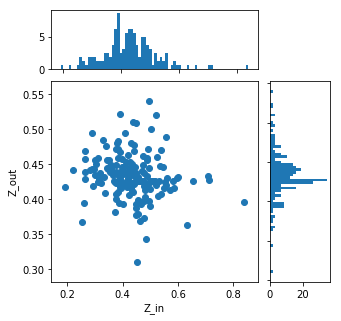

In [43]:


y_pred=d[0,696:870]
y_test=d[0,870:]

print(y_pred.shape,y_test.shape)
# the random data
x = y_test
y = y_pred


fig = plt.figure(figsize=(5,5 ))

gs = GridSpec(4,4)

ax_joint = fig.add_subplot(gs[1:4,0:3])
ax_marg_x = fig.add_subplot(gs[0,0:3])
ax_marg_y = fig.add_subplot(gs[1:4,3])

ax_joint.scatter(x,y)
ax_marg_x.hist(x,70,density=True)
ax_marg_y.hist(y,70,density=True,orientation="horizontal")

# Turn off tick labels on marginals
plt.setp(ax_marg_x.get_xticklabels(), visible=False)
plt.setp(ax_marg_y.get_yticklabels(), visible=False)

# Set labels on joint
ax_joint.set_xlabel('Z_in')
ax_joint.set_ylabel('Z_out')
plt.savefig('z_invsz_out_29k_QSOBAL.jpg')
# Set labels on marginals
#ax_marg_y.set_xlabel('')
#ax_marg_x.set_ylabel('Marginal y label')

In [ ]:
def Loader(X,y,N_sample=20000,epoc=10):
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    batch_size=int(N_sample/epoc)
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=1)
    train_data = []
    for i in range(y_train.shape[0]):
        xt=X_train[i,:].reshape(1,-1)
        train_data.append([Variable(torch.tensor([xt], dtype=torch.float)), y_train[i]])
    
    train_loader = torch.utils.data.DataLoader(train_data, shuffle=True, batch_size=batch_size)

    test_data = []
    for i in range(y_test.shape[0]):
        xtst=X_test[i,:].reshape(1,-1)
        test_data.append([Variable(torch.tensor([xtst], dtype=torch.float)), y_test[i]])
    
    test_loader = torch.utils.data.DataLoader(test_data, shuffle=True, batch_size=batch_size)
    
    val_data = []
    for i in range(y_val.shape[0]):
        xv=X_val[i,:].reshape(1,-1)
        val_data.append([Variable(torch.tensor([xv], dtype=torch.float)), y_val[i]])
    
    val_loader = torch.utils.data.DataLoader(val_data, shuffle=True, batch_size=batch_size)
    return train_loader,test_loader,val_loader

